# PDP（Partial Dependence Plot）とICE（Individual Conditional Expectation）
### PDP
ある特徴量の値を変化させたときの平均的な予測変化を示す  
全サンプルで特徴量「x」を固定値にして平均予測を求め、全体の影響を視覚化する
### ICE
各サンプルごとにその変化を追う  
各サンプルごとに予測値の変化を示し、個々の違いや相互作用を確認できる

In [13]:
import torch
import torch.nn as nn
import numpy as np

# シード固定
torch.manual_seed(42)
np.random.seed(42)

# サンプルデータ生成（回帰タスク： y = 3*x + 2 にノイズ）
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = 3 * X + 2 + np.random.normal(0, 1, X.shape)

# NumPy → Tensor
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# シンプルなMLPモデル
class SimpleMLP(nn.Module):
    def __init__(self, hidden_size=16):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = SimpleMLP(hidden_size=16)

# 簡単な訓練（ここでは数エポックのみ）
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    preds = model(X_tensor)
    loss = criterion(preds, y_tensor)
    loss.backward()
    optimizer.step()

print("Training completed. Final loss:", loss.item())


Training completed. Final loss: 0.8066921234130859


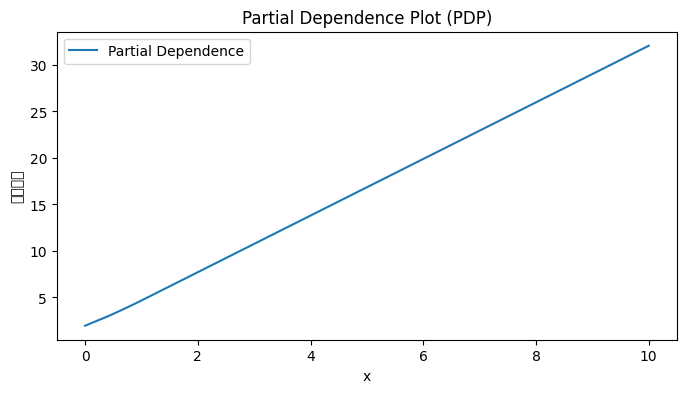

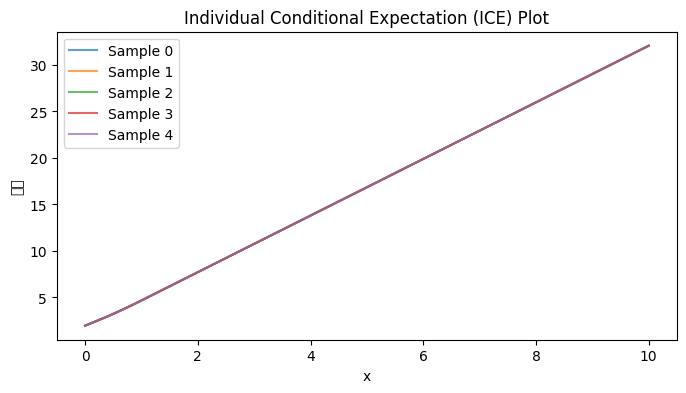

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# predict_fn: NumPy配列を入力として、モデルの予測結果（NumPy配列）を返す関数
def predict_fn(data):
    # dataはNumPy配列
    data_tensor = torch.tensor(data, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        preds = model(data_tensor)
    return preds.numpy()

# PDPの計算：xの範囲に沿って平均予測値を計算
x_range = np.linspace(X.min(), X.max(), 50).reshape(-1, 1)
pdp = []
for val in x_range:
    # 入力全体のxをvalに置き換える
    X_temp = np.full_like(X, val)
    preds = predict_fn(X_temp)
    pdp.append(np.mean(preds))
pdp = np.array(pdp)

plt.figure(figsize=(8, 4))
plt.plot(x_range, pdp, label='Partial Dependence')
plt.xlabel("x")
plt.ylabel("平均予測")
plt.title("Partial Dependence Plot (PDP)")
plt.legend()
plt.show()

# ICEプロットの例：数サンプルについて個別の予測曲線をプロット
plt.figure(figsize=(8, 4))
for i in range(5):  # 先頭5サンプルをプロット
    ice = []
    for val in x_range:
        X_temp = X.copy()
        X_temp[i] = val  # i番目のサンプルだけ値を変更
        preds = predict_fn(X_temp)
        ice.append(preds[i])
    plt.plot(x_range, ice, alpha=0.7, label=f"Sample {i}")
plt.xlabel("x")
plt.ylabel("予測")
plt.title("Individual Conditional Expectation (ICE) Plot")
plt.legend()
plt.show()
